In [1]:
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

from IPython.display import Image

# Import subjects

In [3]:
def get_subject_number(subject_code):
    return str(int(subject_code.split("_")[-1]))

def get_diag_value(file_name):
    if file_name.endswith("_ad.txt"):
        return "AD"
    elif file_name.endswith("_nor.txt"):
        return "CN"
    elif file_name.endswith("_mci.txt"):
        return "MCI"
    else:
        return None
    
data = []

folder_path = "..\\adni-images-Full-resized160x192\\metadata"
for file_name in os.listdir(folder_path):
    if file_name.endswith("new.txt"):
        continue
    if file_name.endswith(".txt"):
        file_path = os.path.join(folder_path, file_name)
        diag = get_diag_value(file_name)
        
        with open(file_path, "r") as file:
            for line in file:
                subj = line.strip()
                subj_number = get_subject_number(subj)
                data.append((subj, subj_number, diag))
                
df = pd.DataFrame(data, columns=["subj", "RID", "diag"])

In [4]:
df.dtypes

subj    object
RID     object
diag    object
dtype: object

In [6]:
print(df["diag"].value_counts())

MCI    317
CN     179
AD     152
Name: diag, dtype: int64


# TAU

Importo le misurazioni delle misurazioni pg/Ml di phosporilated-tau-181 in plasma dei soggetti da diversi studi:
- https://adni.bitbucket.io/reference/blennowplasmatau.html
- https://adni.bitbucket.io/reference/ugotptau181.html
- del terzo non abbiamo file che spiegano

In [31]:
folder_path  = "..\\adni-images-Full-resized160x192\\biospecimen\\"

# Importa il primo file CSV
file_path1 = os.path.join(folder_path, "tau_plasma_BLENNOWPLASMATAU_10Jun2023.csv")
df1 = pd.read_csv(file_path1, usecols=["RID", "PLASMATAU"], dtype={"RID": object, "PLASMATAU": float})
df1.loc[df1["PLASMATAU"] == -4, "PLASMATAU"] = float("nan")

# Importa il secondo file CSV
file_path2 = os.path.join(folder_path, "tau_plasma_FNIH_PLASMA_PTAU181_PROJECT_10Jun2023.csv")
df2 = pd.read_csv(file_path2, usecols=["RID", "PTAU_181"], dtype={"RID": object, "PTAU_181": float})
df2.loc[df2["PTAU_181"] == -4, "PTAU_181"] = float("nan")
df2.rename(columns={"PTAU_181": "PLASMATAU"}, inplace=True)

# Importa il terzo file CSV
file_path3 = os.path.join(folder_path, "tau_plasma_UGOTPTAU181_06_18_20_10Jun2023.csv")
df3 = pd.read_csv(file_path3, usecols=["RID", "PLASMAPTAU181"], dtype={"RID": object, "PLASMAPTAU181": float})
df3.loc[df3["PLASMAPTAU181"] == -4, "PLASMAPTAU181"] = float("nan")
df3.rename(columns={"PLASMAPTAU181": "PLASMATAU"}, inplace=True)

In [30]:
df_tau = pd.concat([df1, df2, df3], ignore_index=True)

In [83]:
df_tau.head()

,RID,PLASMATAU
0,2,2.41
1,3,3.84
2,4,3.76
3,5,3.81
4,6,2.86


In [84]:
len(df_tau)

581

In [85]:
len(df_tau["RID"].value_counts())

581

## Merging with users

In [86]:
df_tau_merged = df.merge(df_tau, on="RID", how="inner")


In [87]:
rid_counts = df_tau_merged["RID"].value_counts()
print(rid_counts)
print(len(rid_counts))
print(sum(rid_counts))


938     1
21      1
899     1
883     1
97      1
       ..
1152    1
1137    1
1024    1
852     1
86      1
Name: RID, Length: 442, dtype: int64
442
442


In [88]:
print(df_tau_merged["diag"].value_counts())

MCI    150
CN     148
AD     144
Name: diag, dtype: int64


In [89]:
df_tau_merged.head()

,subj,RID,diag,PLASMATAU
0,002_S_0938,938,AD,2.64
1,005_S_0221,221,AD,1.74
2,011_S_0010,10,AD,2.74
3,023_S_1289,1289,AD,4.58
4,027_S_0850,850,AD,4.37


Raggruppa per soggetto

In [90]:
df_tau_merged_grouped = df_tau_merged.groupby(['RID', 'diag']).agg({'PLASMATAU': 'mean'}).reset_index()

In [91]:
df_tau_merged_grouped.head()

,RID,diag,PLASMATAU
0,10,AD,2.74
1,1001,AD,4.16
2,1002,CN,2.15
3,101,MCI,1.83
4,1010,MCI,2.83


In [92]:
print(df_tau_merged_grouped["diag"].value_counts())

MCI    150
CN     148
AD     144
Name: diag, dtype: int64


Grafico

In [93]:
df_tau_merged['PLASMATAU'].isna().any()

True

In [94]:
np.isinf(df_tau_merged['PLASMATAU']).any()

False

In [95]:
df_tau_merged.head()

,subj,RID,diag,PLASMATAU
0,002_S_0938,938,AD,2.64
1,005_S_0221,221,AD,1.74
2,011_S_0010,10,AD,2.74
3,023_S_1289,1289,AD,4.58
4,027_S_0850,850,AD,4.37


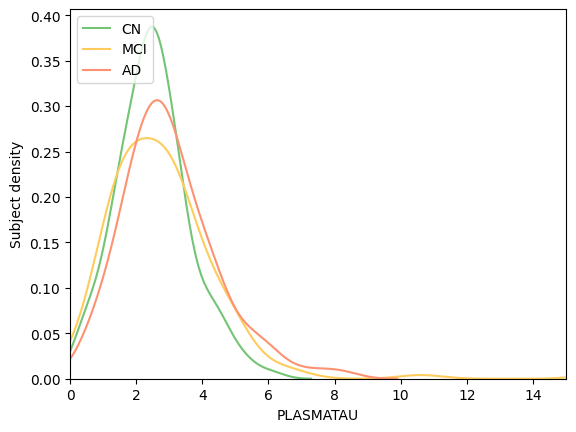

In [96]:
plt.xlim(0, 15)

fig = sns.kdeplot(df_tau_merged[(df_tau_merged['diag'] == 'CN') & (~df_tau_merged['PLASMATAU'].isna())]['PLASMATAU'], color='#74c476')
fig = sns.kdeplot(df_tau_merged[(df_tau_merged['diag'] == 'MCI') & (~df_tau_merged['PLASMATAU'].isna())]['PLASMATAU'], color='#fecc5c')
fig = sns.kdeplot(df_tau_merged[(df_tau_merged['diag'] == 'AD') & (~df_tau_merged['PLASMATAU'].isna())]['PLASMATAU'], color='#fc9272')

plt.legend(['CN', 'MCI', 'AD'], loc='upper left')

fig.set(ylabel='Subject density');

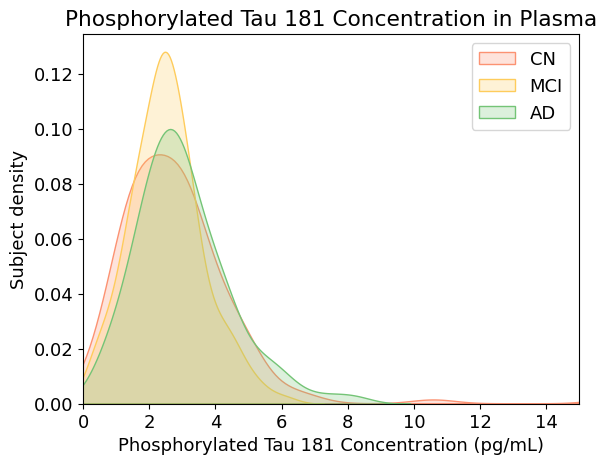

In [193]:
plt.xlim(0, 15)
plt.rcParams.update({'font.size': 13})
colors = ['#74c476', '#fecc5c', '#fc9272']
fig = sns.kdeplot(data = df_tau_merged_grouped[~df_tau_merged_grouped['PLASMATAU'].isna()].reset_index(drop=True), hue = 'diag', x='PLASMATAU', fill = True, palette= colors)
#fig = sns.kdeplot(df_tau_merged[(df_tau_merged['diag'] == 'MCI') & (~df_tau_merged['PLASMATAU'].isna())]['PLASMATAU'], color='#fecc5c')
#fig = sns.kdeplot(df_tau_merged[(df_tau_merged['diag'] == 'AD') & (~df_tau_merged['PLASMATAU'].isna())]['PLASMATAU'], color='#fc9272')

plt.legend(['CN', 'MCI', 'AD'], loc='upper right')

fig.set(ylabel='Subject density', xlabel='Phosphorylated Tau 181 Concentration (pg/mL)', title='Phosphorylated Tau 181 Concentration in Plasma');

# Beta-Amyloid (CSF)

Importo le misurazioni delle misurazioni pg/ml di beta-amyloid in CSF dei soggetti da diversi studi:
- https://adni.bitbucket.io/reference/euroimmun.html
- https://adni.bitbucket.io/reference/fujirebioabeta.html

In particolare importo
- pg/mL Beta-Amyloid 1-42
- pg/mL Beta-Amyloid 1-40
- Beta-Amyloid 1-42/1-40 ratio

In [110]:
folder_path  = "..\\adni-images-Full-resized160x192\\biospecimen\\"

# Importa il primo file CSV
file_path1 = os.path.join(folder_path, "amyloid_csf_ADNI_EUROIMMUN_10Jun2023.csv")
df4 = pd.read_csv(file_path1, usecols=["RID", "BETA_AMYLOID_1_40", "BETA_AMYLOID_1_42", "BETA_AMYLOID_42_40"], dtype={"RID": object, "BETA_AMYLOID_1_40": float, "BETA_AMYLOID_1_42": float, "BETA_AMYLOID_42_40": float})
df4.loc[df4["BETA_AMYLOID_1_40"] == -4, "BETA_AMYLOID_1_40"] = float("nan")
df4.loc[df4["BETA_AMYLOID_1_42"] == -4, "BETA_AMYLOID_1_42"] = float("nan")
df4.loc[df4["BETA_AMYLOID_42_40"] == -4, "BETA_AMYLOID_42_40"] = float("nan")

# Importa il secondo file CSV
file_path2 = os.path.join(folder_path, "amyloid_csf_FUJIREBIOABETA_10Jun2023.csv")
df5 = pd.read_csv(file_path2, usecols=["RID", "ABETA42", "ABETA40", "ABETA42_40"], dtype={"RID": object, "ABETA42": float, "ABETA40": float, "ABETA42_40": float})
df5.loc[df5["ABETA42"] == -4, "ABETA42"] = float("nan")
df5.loc[df5["ABETA40"] == -4, "ABETA40"] = float("nan")
df5.loc[df5["ABETA42_40"] == -4, "ABETA42_40"] = float("nan")
df5.rename(columns={"ABETA42": "BETA_AMYLOID_1_42", "ABETA40": "BETA_AMYLOID_1_40", "ABETA42_40": "BETA_AMYLOID_42_40"}, inplace=True)

In [111]:
df_csf_amyloid = pd.concat([df4, df5], ignore_index=True)

In [112]:
df_csf_amyloid.head()

,RID,BETA_AMYLOID_1_40,BETA_AMYLOID_1_42,BETA_AMYLOID_42_40
0,51,7324.79,264.01,0.036043
1,59,8431.15,1184.28,0.140465
2,232,8454.41,772.85,0.091414
3,259,9887.33,580.35,0.058696
4,272,9835.15,918.71,0.093411


In [113]:
len(df_csf_amyloid)

722

In [114]:
len(df_csf_amyloid["RID"].value_counts())

510

## Merging with users

In [115]:
df_csf_amyloid_merged = df.merge(df_csf_amyloid, on="RID", how="inner")

In [116]:
df_csf_amyloid_merged.head()

,subj,RID,diag,BETA_AMYLOID_1_40,BETA_AMYLOID_1_42,BETA_AMYLOID_42_40
0,023_S_1046,1046,MCI,5926.93,575.45,0.097091
1,023_S_1046,1046,MCI,5926.93,575.45,0.097091
2,128_S_0272,272,CN,9835.15,918.71,0.093411
3,128_S_0272,272,CN,9835.15,918.71,0.093411
4,128_S_0272,272,CN,14934.00,1018.00,0.068000


In [117]:
rid_counts = df_csf_amyloid_merged["RID"].value_counts()
#print(rid_counts)
print(len(rid_counts))
print(sum(rid_counts))

48
79


In [118]:
print(df_csf_amyloid_merged["diag"].value_counts())

MCI    45
CN     34
Name: diag, dtype: int64


Raggruppa per soggetto

In [119]:
df_csf_amyloid_merged_grouped = df_csf_amyloid_merged.groupby(['RID', 'diag']).agg({'BETA_AMYLOID_1_42': 'mean', 'BETA_AMYLOID_1_40': 'mean', 'BETA_AMYLOID_42_40': 'mean'}).reset_index()

In [120]:
df_csf_amyloid_merged_grouped.head()

,RID,diag,BETA_AMYLOID_1_42,BETA_AMYLOID_1_40,BETA_AMYLOID_42_40
0,1010,MCI,398.44,6811.67,0.058494
1,1016,CN,408.00,1665.00,0.245000
2,1043,MCI,671.00,12358.00,0.054000
3,1045,MCI,1387.00,14216.00,0.098000
4,1046,MCI,575.45,5926.93,0.097091


In [121]:
print(df_csf_amyloid_merged_grouped["diag"].value_counts())

MCI    28
CN     20
Name: diag, dtype: int64


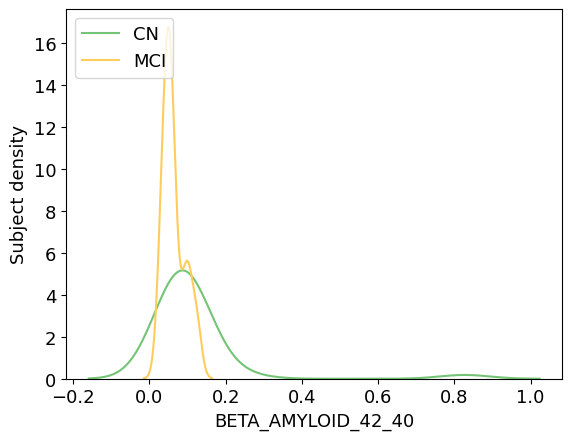

In [190]:
#plt.xlim(0, 15)

fig = sns.kdeplot(df_csf_amyloid_merged[(df_csf_amyloid_merged['diag'] == 'CN') & (~df_csf_amyloid_merged['BETA_AMYLOID_42_40'].isna())]['BETA_AMYLOID_42_40'], color='#74c476')
fig = sns.kdeplot(df_csf_amyloid_merged[(df_csf_amyloid_merged['diag'] == 'MCI') & (~df_csf_amyloid_merged['BETA_AMYLOID_42_40'].isna())]['BETA_AMYLOID_42_40'], color='#fecc5c')
fig = sns.kdeplot(df_csf_amyloid_merged[(df_csf_amyloid_merged['diag'] == 'AD') & (~df_csf_amyloid_merged['BETA_AMYLOID_42_40'].isna())]['BETA_AMYLOID_42_40'], color='#fc9272')

plt.legend(['CN', 'MCI', 'AD'], loc='upper left')

fig.set(ylabel='Subject density');

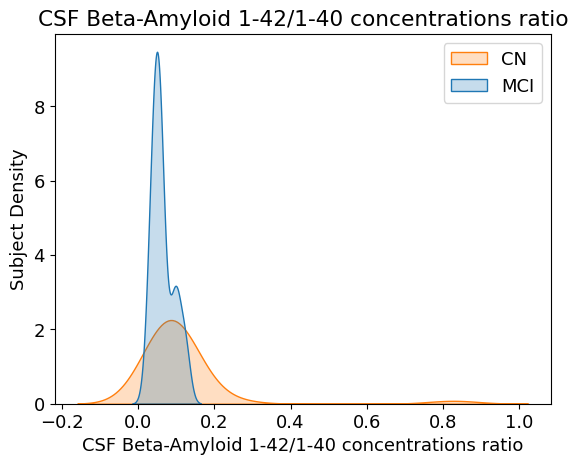

In [127]:
#plt.xlim(0, 4)
plt.rcParams.update({'font.size': 13})
fig = sns.kdeplot(data = df_csf_amyloid_merged[~df_csf_amyloid_merged['BETA_AMYLOID_42_40'].isna()].reset_index(drop=True), hue = 'diag', x='BETA_AMYLOID_42_40', fill = True)
#fig = sns.kdeplot(df_tau_merged[(df_tau_merged['diag'] == 'MCI') & (~df_tau_merged['PLASMATAU'].isna())]['PLASMATAU'], color='#fecc5c')
#fig = sns.kdeplot(df_tau_merged[(df_tau_merged['diag'] == 'AD') & (~df_tau_merged['PLASMATAU'].isna())]['PLASMATAU'], color='#fc9272')

plt.legend(['CN', 'MCI', 'AD'], loc='upper right')

fig.set(ylabel='Subject Density', xlabel='CSF Beta-Amyloid 1-42/1-40 concentrations ratio', title='CSF Beta-Amyloid 1-42/1-40 concentrations ratio');

# Beta-Amyloid (plasma) 

Importo le misurazioni delle misurazioni **ng/ml** di beta-amyloid in PLASMA dei soggetti da diversi studi:
- https://adni.bitbucket.io/reference/docs/BATEMANLAB/Batemanlab_ADNI_Methods_20190612.pdf
- https://adni.bitbucket.io/reference/fujirebioabeta.html
- https://adni.bitbucket.io/reference/plasma_abeta_project_u_of_gothenburg.html
- altri progetti FNIH

In particolare importo
- pg/mL Beta-Amyloid 1-42
- pg/mL Beta-Amyloid 1-40
- Beta-Amyloid 1-42/1-40 ratio

In [128]:
folder_path  = "..\\adni-images-Full-resized160x192\\biospecimen\\"

# Importa il primo file CSV (i valori sono in ng/mL)
file_path1 = os.path.join(folder_path, "amyloid_plasma_batemanlab_20221118_10Jun2023.csv")
df6 = pd.read_csv(file_path1, usecols=["RID", "Abeta_40_conc", "Abeta_42_conc", "Abeta_4240"], dtype={"RID": object, "Abeta_40_conc": float, "Abeta_42_conc": float, "Abeta_4240": float})
df6.loc[df6["Abeta_40_conc"] == -4, "Abeta_40_conc"] = float("nan")
df6.loc[df6["Abeta_42_conc"] == -4, "Abeta_42_conc"] = float("nan")
df6.loc[df6["Abeta_4240"] == -4, "Abeta_4240"] = float("nan")
df6.rename(columns={"Abeta_42_conc": "ABETA42", "Abeta_40_conc": "ABETA40", "Abeta_4240": "ABETA42_40"}, inplace=True)

In [129]:
df6.head()

,RID,ABETA42,ABETA40,ABETA42_40
0,923,0.0472,0.3580,0.131879
1,896,0.0271,0.2553,0.106055
2,5004,0.0341,0.2618,0.130302
3,4094,0.0392,0.2976,0.131616
4,5031,0.0353,0.3011,0.117094


In [130]:

# Importa il primo file CSV (i valori sono in ng/mL)
file_path1 = os.path.join(folder_path, "amyloid_plasma_PLASMA_ABETA_PROJECT_WASH_U_11_05_21_10Jun2023.csv")
df7 = pd.read_csv(file_path1, usecols=["RID", "AB40", "AB42", "PLASMAAB4240"], dtype={"RID": object, "AB40": float, "AB42": float, "PLASMAAB4240": float})
df7.loc[df7["AB40"] == -4, "AB40"] = float("nan")
df7.loc[df7["AB42"] == -4, "AB42"] = float("nan")
df7.loc[df7["PLASMAAB4240"] == -4, "PLASMAAB4240"] = float("nan")
df7.rename(columns={"AB42": "ABETA42", "AB40": "ABETA40", "PLASMAAB4240": "ABETA42_40"}, inplace=True)


In [131]:
df7.head()

,RID,ABETA40,ABETA42,ABETA42_40
0,31,0.359436,0.044527,0.123881
1,138,0.353607,0.042668,0.120664
2,150,0.299507,0.037770,0.126108
3,214,0.274496,0.032107,0.116968
4,303,0.317690,0.042056,0.132381


In [132]:
# Importa il primo file CSV (i valori sono in ng/mL)
file_path1 = os.path.join(folder_path, "amyloid_plasma_PLASMA_ABETA_PROJECT_U_OF_GOTHENBURG_10Jun2023.csv")
df8 = pd.read_csv(file_path1, usecols=["RID", "AB_1_40", "AB_1_42"], dtype={"RID": object, "AB_1_40": float, "AB_1_42": float})
df8.loc[df8["AB_1_40"] == -4, "AB_1_40"] = float("nan")
df8.loc[df8["AB_1_42"] == -4, "AB_1_42"] = float("nan")
df8["AB_1_40"] = df8["AB_1_40"] / 1000
df8["AB_1_42"] = df8["AB_1_42"] / 1000
df8["PLASMAAB4240"] = df8["AB_1_42"] / df8["AB_1_40"]
df8.rename(columns={"AB_1_42": "ABETA42", "AB_1_40": "ABETA40", "PLASMAAB4240": "ABETA42_40"}, inplace=True)


In [133]:
df8.head()

,RID,ABETA40,ABETA42,ABETA42_40
0,31,0.379,0.0207,0.054617
1,138,0.305,0.0242,0.079344
2,150,0.284,0.0137,0.048239
3,214,0.256,0.0138,0.053906
4,303,0.326,0.0251,0.076994


In [178]:
df_plasma_amyloid = pd.concat([df6, df7, df8], ignore_index=True)

In [179]:
df_plasma_amyloid.head()

,RID,ABETA42,ABETA40,ABETA42_40
0,923,0.0472,0.3580,0.131879
1,896,0.0271,0.2553,0.106055
2,5004,0.0341,0.2618,0.130302
3,4094,0.0392,0.2976,0.131616
4,5031,0.0353,0.3011,0.117094


In [180]:
len(df_plasma_amyloid)

1002

In [181]:
len(df_plasma_amyloid["RID"].value_counts())

418

## Merging with users

In [182]:
df_plasma_amyloid_merged = df.merge(df_plasma_amyloid, on="RID", how="inner")

In [183]:
rid_counts = df_plasma_amyloid_merged["RID"].value_counts()
#print(rid_counts)
print(len(rid_counts))
print(sum(rid_counts))

45
145


In [184]:
print(df_plasma_amyloid_merged["diag"].value_counts())

CN     103
MCI     42
Name: diag, dtype: int64


Raggruppa per soggetto

In [185]:
df_plasma_amyloid_merged_grouped = df_plasma_amyloid_merged.groupby(['RID', 'diag']).agg({'ABETA42': 'mean', 'ABETA40': 'mean', 'ABETA42_40': 'mean'}).reset_index()

In [186]:
df_plasma_amyloid_merged_grouped.head()

,RID,diag,ABETA42,ABETA40,ABETA42_40
0,1016,CN,0.033020,0.273780,0.120559
1,1045,MCI,0.043900,0.315250,0.139519
2,1098,CN,0.028907,0.266347,0.106260
3,1106,MCI,0.033800,0.242400,0.139299
4,112,MCI,0.029700,0.240100,0.123693


In [187]:
print(df_plasma_amyloid_merged_grouped["diag"].value_counts())

CN     29
MCI    16
Name: diag, dtype: int64


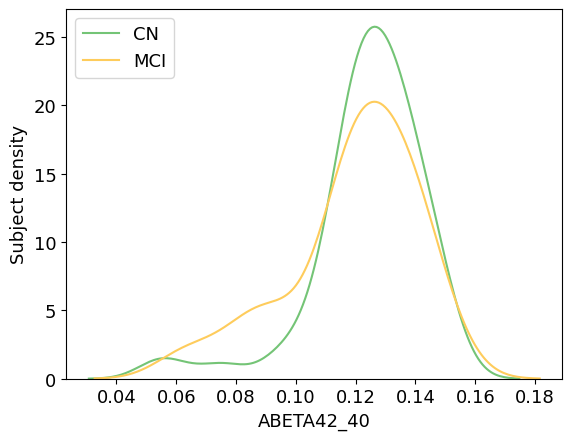

In [191]:
#plt.xlim(0, 15)

fig = sns.kdeplot(df_plasma_amyloid_merged[(df_plasma_amyloid_merged['diag'] == 'CN') & (~df_plasma_amyloid_merged['ABETA42_40'].isna())]['ABETA42_40'], color='#74c476')
fig = sns.kdeplot(df_plasma_amyloid_merged[(df_plasma_amyloid_merged['diag'] == 'MCI') & (~df_plasma_amyloid_merged['ABETA42_40'].isna())]['ABETA42_40'], color='#fecc5c')
fig = sns.kdeplot(df_plasma_amyloid_merged[(df_plasma_amyloid_merged['diag'] == 'AD') & (~df_plasma_amyloid_merged['ABETA42_40'].isna())]['ABETA42_40'], color='#fc9272')

plt.legend(['CN', 'MCI', 'AD'], loc='upper left')

fig.set(ylabel='Subject density');

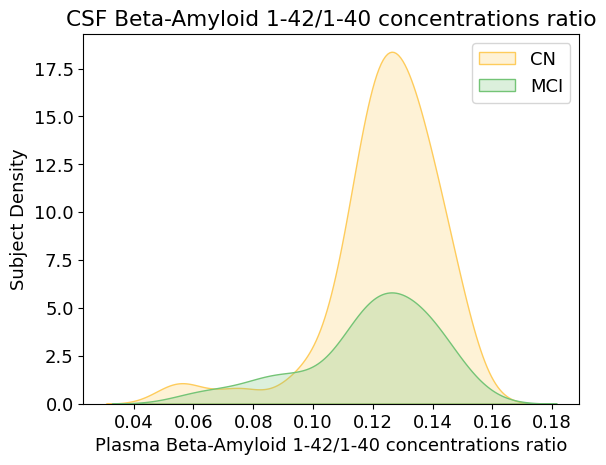

In [196]:
#plt.xlim(0, 4)
plt.rcParams.update({'font.size': 13})
colors = ['#74c476', '#fecc5c']
fig = sns.kdeplot(data = df_plasma_amyloid_merged[~df_plasma_amyloid_merged['ABETA42_40'].isna()].reset_index(drop=True), hue = 'diag', x='ABETA42_40', fill = True, palette = colors)
#fig = sns.kdeplot(df_tau_merged[(df_tau_merged['diag'] == 'MCI') & (~df_tau_merged['PLASMATAU'].isna())]['PLASMATAU'], color='#fecc5c')
#fig = sns.kdeplot(df_tau_merged[(df_tau_merged['diag'] == 'AD') & (~df_tau_merged['PLASMATAU'].isna())]['PLASMATAU'], color='#fc9272')

plt.legend(['CN', 'MCI', 'AD'], loc='upper right')

fig.set(ylabel='Subject Density', xlabel='Plasma Beta-Amyloid 1-42/1-40 concentrations ratio', title='CSF Beta-Amyloid 1-42/1-40 concentrations ratio');